In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

sub_size = 20
X_size = 300

X_star = np.linspace(1, 1.2, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)  # Generate sub_size evenly spaced indices.

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 1  # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup)  # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)      #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)     # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                # Primal form of the Sample Set Feature Function

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

X = X_star.reshape(-1,1)
X = X[1:, :]
KK = RBF_kernel(X, X_sub, kTup)     

X_diag = np.diag(X.flatten())  # Sample Set Diagonal Matrix
X_sub_diag = np.diag(X_sub.flatten()) # Subsample Diagonal Matrix
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                   # Primal form of the Sample Set Feature Function

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                                 #First-Order Derivative of the Sample Set Feature Function

A = np.real(X_F_D)
B = np.real(X_F)
C = np.real(X_F_1)

n = X_size - 1      
m_vars = sub_size 

r = 1000000 #Hyperparameter: gamma

# Differential equation parameters
p = 0
t = X
I = np.ones((n, 1))          
E = np.eye(m_vars)           

d = m_vars 

# Initial Guess
w = np.zeros((d, 1), dtype=np.float64)
b = 0.0
m = 0.0
y = np.log(t)+ 1.0

max_iter = 50     
tol = 1e-10           

# Construct the matrix equation and solve it.
def compute_residuals(w, b, m, y):
    term1 = A @ w
    sqrt_term = np.sqrt(y - np.log(t))
    term2 = (2 / t) * sqrt_term + (1 / t)
    Y1 = w + r * A.T @ (term1 - term2) + r * (-B.T) @ (y - B @ w - b * I) + m * C.T
    Y2 = r * (-I.T) @ (y - B @ w - b * I) + m
    Y3 = (C @ w + b - p).item()
    term4 = (A @ w - (2 / t) * sqrt_term - (1 / t))
    Y4 = -r * term4 / (t * sqrt_term) + r * (y - B @ w - b * I)
    return Y1, Y2.item(), Y3, Y4

def compute_jacobian(w, b, m, y):
    J = np.zeros((n+m_vars+1+1, n+m_vars+1+1))
    n_w= m_vars
    n_y = n

    # Y1 derivatives
    J[:n_w, :n_w] = np.eye(n_w) + r * A.T @ A + r * B.T @ B
    J[:n_w, n_w] = (r * B.T @ I).flatten()
    J[:n_w, n_w+1] = C.T.flatten()
    diag_y1 = np.diag((1 / t.flatten()) / np.sqrt(y.flatten() - np.log(t.flatten())))
    J[:n_w, n_w+2:] = -r * (A.T @ diag_y1 + B.T)

    # Y2 derivatives
    J[n_w, :n_w] = (r * I.T @ B).flatten()
    J[n_w, n_w] = r * (I.T @ I).item()
    J[n_w, n_w] = 1
    J[n_w, n_w+2:] = -r * I.T.flatten()

    # Y3 derivatives
    J[n_w+1, :n_w] = C.flatten()
    J[n_w+1, n_w] = 1

    # Y4 derivatives
    sqrt_term = np.sqrt(y - np.log(t))
    diag_denom = np.diag(1 / (t.flatten() * sqrt_term.flatten()))
    J[n_w+2:, :n_w] = -r * (diag_denom @ A + B)
    J[n_w+2:, n_w] = -r * I.flatten()
    
    diag1 = np.diag(1 / (t.flatten()**2 * (y.flatten() - np.log(t.flatten()))))
    term_u = (A @ w - (2 / t) * sqrt_term - (1 / t)).flatten()
    diag2 = np.diag(term_u / (2 * t.flatten() * (y.flatten() - np.log(t.flatten()))**1.5))
    J[n_w+2:, n_w+2:] = r * (diag1 + diag2 + np.eye(n_y))
    return J

for iter in range(max_iter):
    Y1, Y2, Y3, Y4 = compute_residuals(w, b, m, y)
    residual = np.concatenate([Y1.flatten(), [Y2, Y3], Y4.flatten()])
    res_norm = np.linalg.norm(residual)
    print(f"Iter {iter}: Residual = {res_norm:.6f}")
    if res_norm < tol:
        print("Converged!")
        break
    n_w= m_vars
    n_y = n
    
    J = compute_jacobian(w, b, m, y)
    delta = np.linalg.solve(J, -residual)
    w += delta[:n_w].reshape(-1, 1)
    b += delta[n_w]
    m += delta[n_w+1]
    y += delta[n_w+2:].reshape(-1, 1)
    y = np.maximum(y, np.log(t) + 1e-10)  # Ensure y > log(t)
print("Final variables:")
print("w:", w.flatten())
print("b:", b)
print("m:", m)
print("y:", y.flatten())

#Calculate the prediction results.
X = X_star.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)   
eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)
F = K_1 @ A_lam
X_F = F                            

y_p =  np.real(np.dot(X_F,w) + b)
# print(y_p)

Iter 0: Residual = 3941899344.362168
Iter 1: Residual = 635732021.404885
Iter 2: Residual = 855426013.469584
Iter 3: Residual = 16423176.664732
Iter 4: Residual = 123282460.560055
Iter 5: Residual = 1317078.066881
Iter 6: Residual = 29517248.889492
Iter 7: Residual = 255743.509366
Iter 8: Residual = 9315272.628582
Iter 9: Residual = 67578.582392
Iter 10: Residual = 3653167.024640
Iter 11: Residual = 19881.993246
Iter 12: Residual = 1598810.320140
Iter 13: Residual = 7680.375005
Iter 14: Residual = 771920.315499
Iter 15: Residual = 4482.862856
Iter 16: Residual = 393822.780312
Iter 17: Residual = 2565.179576
Iter 18: Residual = 223829.507232
Iter 19: Residual = 1501.229482
Iter 20: Residual = 115766.172530
Iter 21: Residual = 553.279977
Iter 22: Residual = 58157.042533
Iter 23: Residual = 173.994110
Iter 24: Residual = 13182.209274
Iter 25: Residual = 5.746693
Iter 26: Residual = 598.748392
Iter 27: Residual = 0.099373
Iter 28: Residual = 0.115109
Iter 29: Residual = 0.059801
Iter 30: R

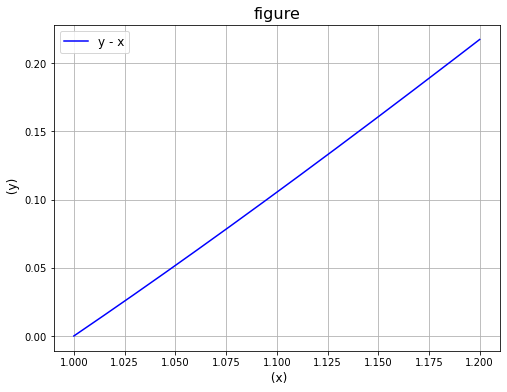

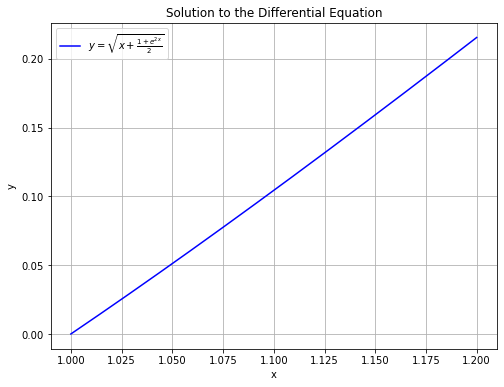

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#graph of the predicted values
x = X 
a = y_p
y = y_p               
plt.figure(figsize=(8, 6)) 
plt.plot(x, y, label="y - x", color="blue", linestyle="-")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

#graph of the true values
# Define the solution function
def y(x):
    return  (np.log(x))**2 + np.log(x)
x = X_star  
y_vals = y(x)
b = y_vals
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y_vals, 'b-', label=r'$y = \sqrt{x + \frac{1 + e^{2x}}{2}}$')
plt.title('Solution to the Differential Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true.reshape(-1, 1))
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true.reshape(-1, 1))
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true.reshape(-1, 1), squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)

print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


import pandas as pd

data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})

data_to_save.to_csv('fsvm_06.csv', index=False)
print("fsvm_06.csv")

R2_fsvm: 0.9997419237336829, mae_fsvm: 0.0008880702638397582, rmse_fsvm: 0.00101264057253833, inf_norm_fsvm: 0.0017031609384061952
